# CIC IIoT Dataset 2025 - Anomaly Detection

Unsupervised anomaly detection for identifying attacks without labels.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, recall_score, 
    balanced_accuracy_score,
    matthews_corrcoef
)
import warnings
warnings.filterwarnings('ignore')

# Create figures directory
os.makedirs('figures', exist_ok=True)

sns.set_style('whitegrid')

## 1. Load and Prepare Data

In [19]:
# Load data
attack_df = pd.read_csv('dataset/attack_samples_1sec.csv')
benign_df = pd.read_csv('dataset/benign_samples_1sec.csv')

print(f"Attack samples: {len(attack_df):,}")
print(f"Benign samples: {len(benign_df):,}")

Attack samples: 90,391
Benign samples: 136,800


In [20]:
# Add binary label
benign_df['label1'] = 'benign'
attack_df['label1'] = 'attack'

# Combine datasets
df = pd.concat([attack_df, benign_df], ignore_index=True)
print(f"Total samples: {len(df):,}")

Total samples: 227,191


## 2. Feature Engineering

In [21]:
# Identify feature columns (numeric only)
exclude_cols = ['device_name', 'device_mac', 'label_full', 'label1', 'label2', 
                'label3', 'label4', 'timestamp', 'timestamp_start', 'timestamp_end',
                'log_data-types', 'network_ips_all', 'network_ips_dst', 'network_ips_src',
                'network_macs_all', 'network_macs_dst', 'network_macs_src',
                'network_ports_all', 'network_ports_dst', 'network_ports_src',
                'network_protocols_all', 'network_protocols_dst', 'network_protocols_src']

feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"Number of features: {len(feature_cols)}")

# Extract features and labels
X = df[feature_cols].copy()
y_true = df['label1'].copy()

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Feature matrix shape: {X.shape}")
print(f"True labels: {y_true.value_counts()}")

Number of features: 71
Feature matrix shape: (227191, 71)
True labels: label1
benign    136800
attack     90391
Name: count, dtype: int64


## 3. Train-Test Split

In [22]:
# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, test_size=0.3, random_state=42, stratify=y_true
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Training samples: 159,033
Test samples: 68,158


In [23]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Feature scaling completed


## 4. Evaluation Functions

In [24]:
def evaluate_anomaly_detector(y_true, y_pred, model_name):
    """
    Evaluate anomaly detector
    y_pred: -1 for anomaly (attack), 1 for normal (benign)
    """
    # Convert predictions: -1 -> attack, 1 -> benign
    y_pred_labels = ['attack' if p == -1 else 'benign' for p in y_pred]
    
    results = {}
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    results['confusion_matrix'] = cm
    
    # Precision, Recall
    results['precision'] = precision_score(y_true, y_pred_labels, pos_label='attack', zero_division=0)
    results['recall'] = recall_score(y_true, y_pred_labels, pos_label='attack', zero_division=0)
    
    # Balanced Accuracy
    results['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred_labels)
    
    # Matthews Correlation Coefficient
    results['mcc'] = matthews_corrcoef(y_true, y_pred_labels)
    
    # Calculate detection metrics
    tn, fp, fn, tp = cm.ravel()
    results['true_positives'] = tp
    results['false_positives'] = fp
    results['true_negatives'] = tn
    results['false_negatives'] = fn
    
    return results

def print_results(results, model_name):
    """
    Print evaluation results
    """
    print(f"\n{model_name} - Anomaly Detection")
    print("="*50)
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"Balanced Accuracy: {results['balanced_accuracy']:.4f}")
    print(f"MCC: {results['mcc']:.4f}")
    print(f"\nConfusion Matrix:")
    print(results['confusion_matrix'])
    print(f"\nDetection Details:")
    print(f"  True Positives (attacks detected): {results['true_positives']:,}")
    print(f"  False Positives (benign as attack): {results['false_positives']:,}")
    print(f"  True Negatives (benign detected): {results['true_negatives']:,}")
    print(f"  False Negatives (attacks missed): {results['false_negatives']:,}")

def plot_confusion_matrix(cm, labels, title, filename=None):
    """
    Plot and save confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if filename:
        plt.savefig(f'figures/{filename}', dpi=300, bbox_inches='tight')
        print(f"Saved: figures/{filename}")
    plt.show()

## 5. Anomaly Detection Algorithms

### 5.1 Isolation Forest

In [25]:
# Train Isolation Forest
print("Training Isolation Forest...")
contamination = len(attack_df) / len(df)
print(f"Contamination (attack ratio): {contamination:.4f}")

iso_forest = IsolationForest(
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train_scaled)

# Predictions
y_pred_iso = iso_forest.predict(X_test_scaled)

# Evaluate
results_iso = evaluate_anomaly_detector(y_test, y_pred_iso, "Isolation Forest")
print_results(results_iso, "Isolation Forest")

Training Isolation Forest...
Contamination (attack ratio): 0.3979

Isolation Forest - Anomaly Detection
Precision: 0.6967
Recall: 0.7044
Balanced Accuracy: 0.7509
MCC: 0.5009

Confusion Matrix:
[[19103  8015]
 [ 8316 32724]]

Detection Details:
  True Positives (attacks detected): 32,724
  False Positives (benign as attack): 8,015
  True Negatives (benign detected): 19,103
  False Negatives (attacks missed): 8,316


Saved: figures/isolation_forest_cm.pdf


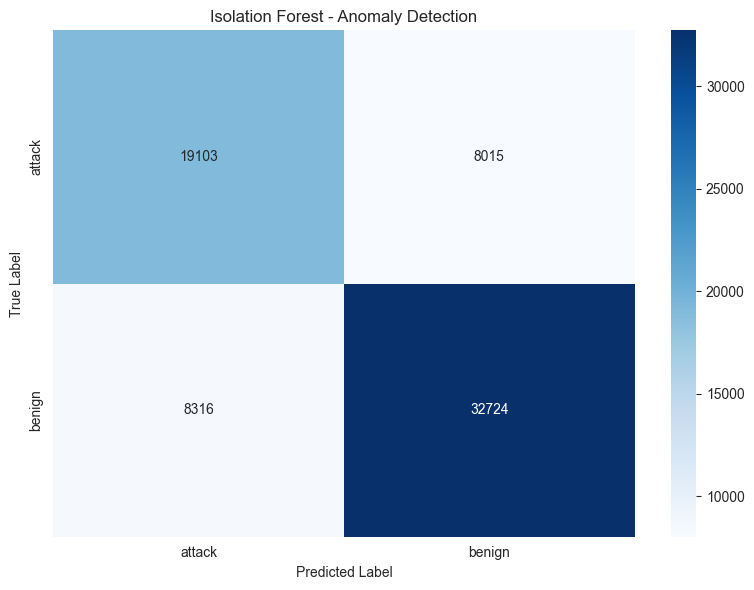

In [26]:
# Plot confusion matrix
plot_confusion_matrix(results_iso['confusion_matrix'], 
                     ['attack', 'benign'], 
                     'Isolation Forest - Anomaly Detection', 'isolation_forest_cm.pdf')

### 5.2 MiniBatch K-Means

In [27]:
# Train MiniBatch K-Means for clustering-based anomaly detection
print("Training MiniBatch K-Means...")
from sklearn.cluster import MiniBatchKMeans

# Use KMeans for clustering (memory efficient)
kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=1000, n_init=3)
kmeans.fit(X_train_scaled)

# Predict on test
y_pred_kmeans = kmeans.predict(X_test_scaled)

# Convert: assume cluster with fewer samples is anomaly
cluster_counts = pd.Series(y_pred_kmeans).value_counts()
anomaly_cluster = cluster_counts.idxmin()

y_pred_kmeans_converted = np.where(y_pred_kmeans == anomaly_cluster, -1, 1)

print(f"Clusters found: 2")
print(f"Anomaly cluster size: {(y_pred_kmeans == anomaly_cluster).sum():,}")

# Evaluate
results_kmeans = evaluate_anomaly_detector(y_test, y_pred_kmeans_converted, "MiniBatch K-Means")
print_results(results_kmeans, "MiniBatch K-Means")

Training MiniBatch K-Means...
Clusters found: 2
Anomaly cluster size: 29,642

MiniBatch K-Means - Anomaly Detection
Precision: 0.5393
Recall: 0.5895
Balanced Accuracy: 0.6284
MCC: 0.2536

Confusion Matrix:
[[15987 11131]
 [13655 27385]]

Detection Details:
  True Positives (attacks detected): 27,385
  False Positives (benign as attack): 11,131
  True Negatives (benign detected): 15,987
  False Negatives (attacks missed): 13,655


Saved: figures/kmeans_cm.pdf


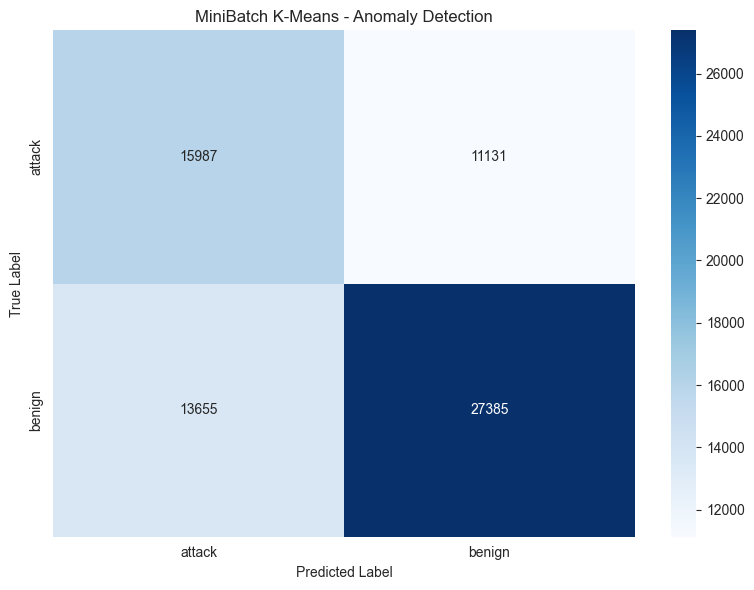

In [28]:
# Plot confusion matrix
plot_confusion_matrix(results_kmeans['confusion_matrix'], 
                     ['attack', 'benign'], 
                     'MiniBatch K-Means - Anomaly Detection', 'kmeans_cm.pdf')

### 5.3 Elliptic Envelope (Robust Covariance)

In [29]:
# Train Elliptic Envelope
print("Training Elliptic Envelope...")
print("Note: This may take a while for large datasets...")

# Use subset for training due to computational constraints
subset_size = min(50000, len(X_train_scaled))
indices = np.random.choice(len(X_train_scaled), subset_size, replace=False)
X_train_subset = X_train_scaled[indices]

elliptic = EllipticEnvelope(
    contamination=contamination,
    random_state=42
)
elliptic.fit(X_train_subset)

# Predictions
y_pred_elliptic = elliptic.predict(X_test_scaled)

# Evaluate
results_elliptic = evaluate_anomaly_detector(y_test, y_pred_elliptic, "Elliptic Envelope")
print_results(results_elliptic, "Elliptic Envelope")

Training Elliptic Envelope...
Note: This may take a while for large datasets...

Elliptic Envelope - Anomaly Detection
Precision: 0.7054
Recall: 0.7117
Balanced Accuracy: 0.7577
MCC: 0.5146

Confusion Matrix:
[[19301  7817]
 [ 8060 32980]]

Detection Details:
  True Positives (attacks detected): 32,980
  False Positives (benign as attack): 7,817
  True Negatives (benign detected): 19,301
  False Negatives (attacks missed): 8,060


Saved: figures/elliptic_envelope_cm.pdf


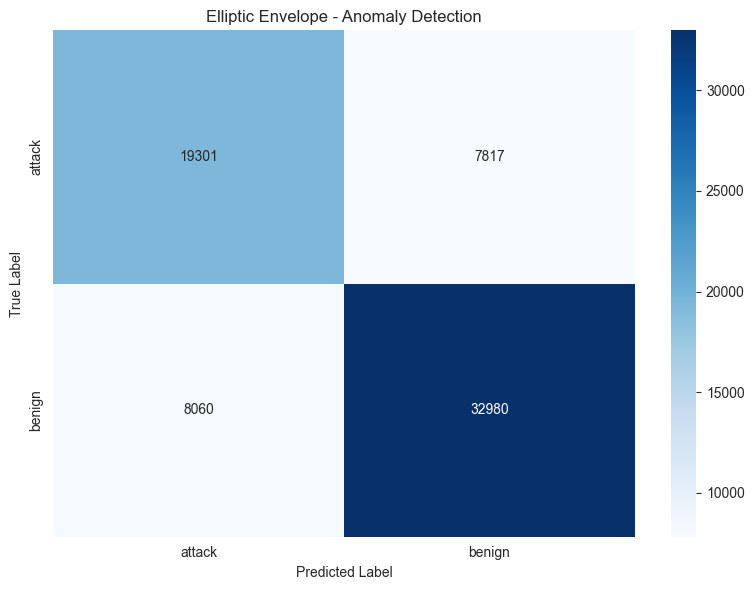

In [30]:
# Plot confusion matrix
plot_confusion_matrix(results_elliptic['confusion_matrix'], 
                     ['attack', 'benign'], 
                     'Elliptic Envelope - Anomaly Detection', 'elliptic_envelope_cm.pdf')

## 6. Comparison of Anomaly Detection Methods

In [31]:
# Compare all anomaly detection methods
anomaly_comparison = pd.DataFrame({
    'Model': ['Isolation Forest', 'MiniBatch K-Means', 'Elliptic Envelope'],
    'Precision': [results_iso['precision'], results_kmeans['precision'], results_elliptic['precision']],
    'Recall': [results_iso['recall'], results_kmeans['recall'], results_elliptic['recall']],
    'Balanced Accuracy': [results_iso['balanced_accuracy'], results_kmeans['balanced_accuracy'], results_elliptic['balanced_accuracy']],
    'MCC': [results_iso['mcc'], results_kmeans['mcc'], results_elliptic['mcc']]
})

print("\nAnomaly Detection Results Comparison:")
print(anomaly_comparison.to_string(index=False))


Anomaly Detection Results Comparison:
            Model  Precision   Recall  Balanced Accuracy      MCC
 Isolation Forest   0.696707 0.704440           0.750904 0.500887
MiniBatch K-Means   0.539336 0.589535           0.628405 0.253554
Elliptic Envelope   0.705420 0.711741           0.757674 0.514580


Saved: figures/anomaly_detection_comparison.pdf


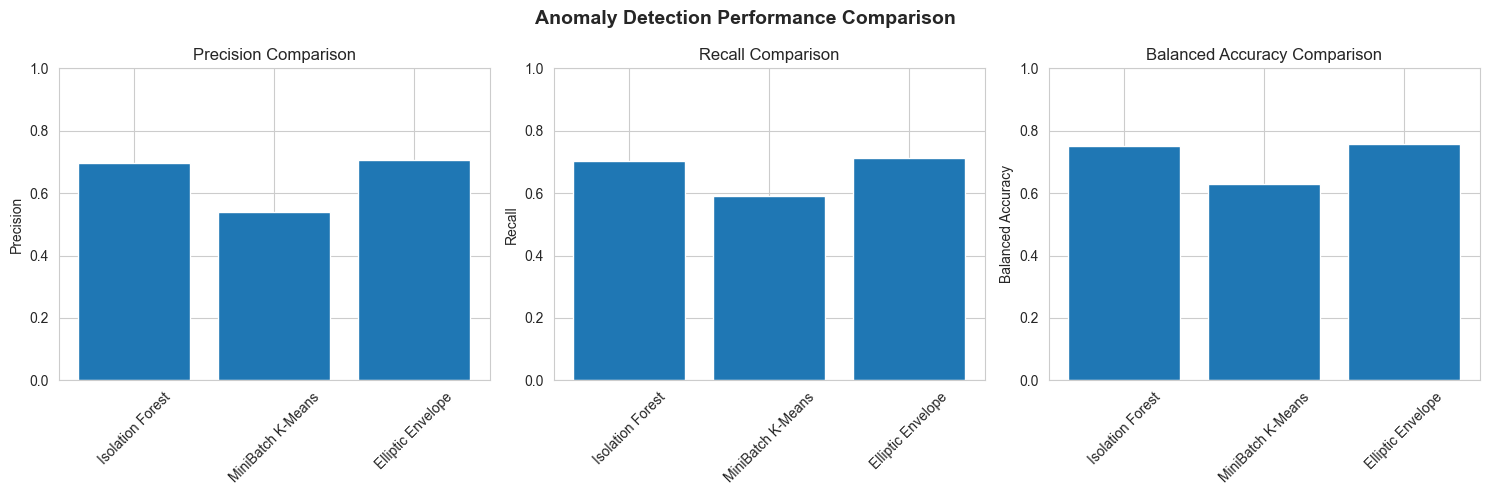

In [32]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Precision', 'Recall', 'Balanced Accuracy']
for idx, metric in enumerate(metrics):
    axes[idx].bar(anomaly_comparison['Model'], anomaly_comparison[metric])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([0, 1])
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Anomaly Detection Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/anomaly_detection_comparison.pdf', dpi=300, bbox_inches='tight')
print("Saved: figures/anomaly_detection_comparison.pdf")
plt.show()

## 7. Summary

In [33]:
print("="*80)
print("ANOMALY DETECTION RESULTS SUMMARY")
print("="*80)
print("\nUnsupervised Anomaly Detection Methods:")
print(anomaly_comparison.to_string(index=False))
print("\n" + "="*80)
print("\nKey Findings:")
print(f"- Best Precision: {anomaly_comparison.loc[anomaly_comparison['Precision'].idxmax(), 'Model']}")
print(f"- Best Recall: {anomaly_comparison.loc[anomaly_comparison['Recall'].idxmax(), 'Model']}")
print(f"- Best Balanced Accuracy: {anomaly_comparison.loc[anomaly_comparison['Balanced Accuracy'].idxmax(), 'Model']}")
print(f"- Best MCC: {anomaly_comparison.loc[anomaly_comparison['MCC'].idxmax(), 'Model']}")

ANOMALY DETECTION RESULTS SUMMARY

Unsupervised Anomaly Detection Methods:
            Model  Precision   Recall  Balanced Accuracy      MCC
 Isolation Forest   0.696707 0.704440           0.750904 0.500887
MiniBatch K-Means   0.539336 0.589535           0.628405 0.253554
Elliptic Envelope   0.705420 0.711741           0.757674 0.514580


Key Findings:
- Best Precision: Elliptic Envelope
- Best Recall: Elliptic Envelope
- Best Balanced Accuracy: Elliptic Envelope
- Best MCC: Elliptic Envelope
